# RaceID progenitor 

In [1]:
library(RaceID, quietly = TRUE)
library(Seurat, quietly = TRUE)

library(dplyr, quietly = TRUE)

library(ggplot2, quietly = TRUE)
library(patchwork, quietly = TRUE)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
# Set working directory to project root
setwd("/research/peer/fdeckert/FD20200109SPLENO")

In [3]:
# Source files
source("plotting_global.R")
source("bin/seurat_function.R")

# Parameter settings

In [4]:
# Seurat files 
so_file <- "data/object/seurat.rds"

# Plotting Theme
ggplot2::theme_set(theme_global_set()) # From project global source()

# Import Seurat 

In [11]:
so <- readRDS(so_file)

# Split data bei treatment and tissue group 

In [12]:
so_1 <- so[[1]]
so_2 <- so[[2]]

# Create SCseq Object

In [7]:
sc_1 <- SCseq(expdata = GetAssayData(so_1, slot = "counts", assay = "RNA"))
sc_2 <- SCseq(expdata = GetAssayData(so_2, slot = "counts", assay = "RNA"))

# SCseq filter data

Filterdata can be run with LBatch and bmode to remove genes associated with batch effects. VarID workflow also allows regression of batch effect in pruneKnn with regNB. in that case the regNB parameter of the compNoise function needs to be TRUE as well. Additional variables can be regressed out using the regVar variable with a data.frame. The rownames correspond to cell id and columns to values e.g. cell cycle. 

In [8]:
sc_1 <- filterdata(sc_1, mintotal = 1500, minexpr = 5, minnumber = 5)
sc_2 <- filterdata(sc_2, mintotal = 1500, minexpr = 5, minnumber = 5)

# Filtered expression matrix

In [10]:
expdata_1 <- getExpData(sc_1)
expdata_2 <- getExpData(sc_2)

# Prune KNN and compute cluster with transition probabilities

In [14]:
res_1   <- pruneKnn(expdata_1, large = TRUE, regNB = TRUE, regVar = so_1[["msCC_diff_RNA"]])
cl_1    <- graphCluster(res_1, pvalue = 0.01)
probs_1 <- transitionProbs(res_1, cl_1)

res_2   <- pruneKnn(expdata_2, large = TRUE, regNB = TRUE, regVar = so_2[["msCC_diff_RNA"]])
cl_2    <- graphCluster(res_2, pvalue = 0.01)
probs_2 <- transitionProbs(res_2, cl_2)

# Compute noise from corrected variance

In [ ]:
noise_1 <- compNoise(expdata_1, res_1, regNB = TRUE, regVar = so_1[["msCC_diff_RNA"]], pvalue = 0.01)
noise_2 <- compNoise(expdata_2, res_2, regNB = TRUE, regVar = so_1[["msCC_diff_RNA"]], pvalue = 0.01)

# Update SCseq object 

In [ ]:
sc_1 <- updateSC(sc_1, res = res_1, cl = cl_1, noise = noise_1, flo = .1)
sc_2 <- updateSC(sc_2, res = res_2, cl = cl_2, noise = noise_2, flo = .1)

# Save output

In [ ]:
saveRDS(sc_1, "data/object/components/raceid_progenitor_nacl.rds")
saveRDS(sc_2, "data/object/components/raceid_progenitor_cpg.rds")

saveRDS(res_1, "data/object/components/raceid_progenitor_nacl_res.rds")
saveRDS(res_2, "data/object/components/raceid_progenitor_cpg_res.rds")

saveRDS(cl_1, "data/object/components/raceid_progenitor_nacl_cl.rds")
saveRDS(cl_2, "data/object/components/raceid_progenitor_cpg_cl.rds")

saveRDS(probs_1, "data/object/components/raceid_progenitor_nacl_probs.rds")
saveRDS(probs_2, "data/object/components/raceid_progenitor_cpg_probs.rds")

In [5]:
# sc_1 <- readRDS("data/object/components/raceid_progenitor_nacl.rds")
# sc_2 <- readRDS("data/object/components/raceid_progenitor_cpg.rds")

# res_1 <- readRDS("data/object/components/raceid_progenitor_nacl_res.rds")
# res_2 <- readRDS("data/object/components/raceid_progenitor_cpg_res.rds")

# cl_1 <- readRDS("data/object/components/raceid_progenitor_nacl_cl.rds")
# cl_2 <- readRDS("data/object/components/raceid_progenitor_cpg_cl.rds")

# probs_1 <- readRDS("data/object/components/raceid_progenitor_nacl_probs.rds")
# probs_2 <- readRDS("data/object/components/raceid_progenitor_cpg_probs.rds")

# Dimensional reduction 

In [6]:
sc_1 <- compumap(sc_1, spread = 3)
sc_2 <- compumap(sc_2, spread = 3)

# Plot 

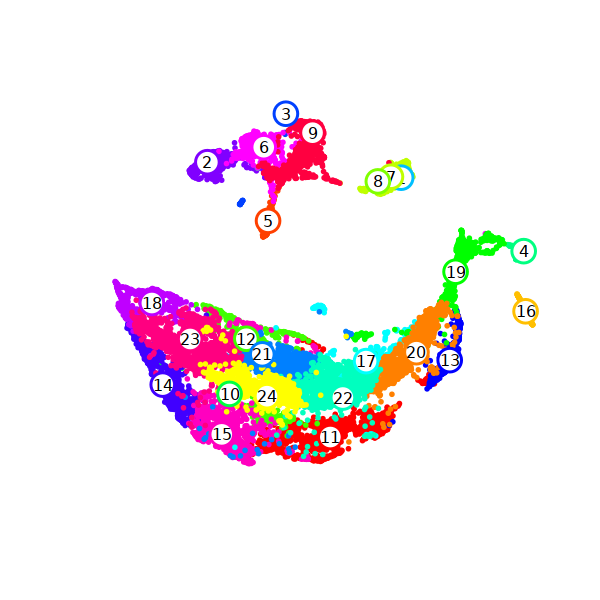

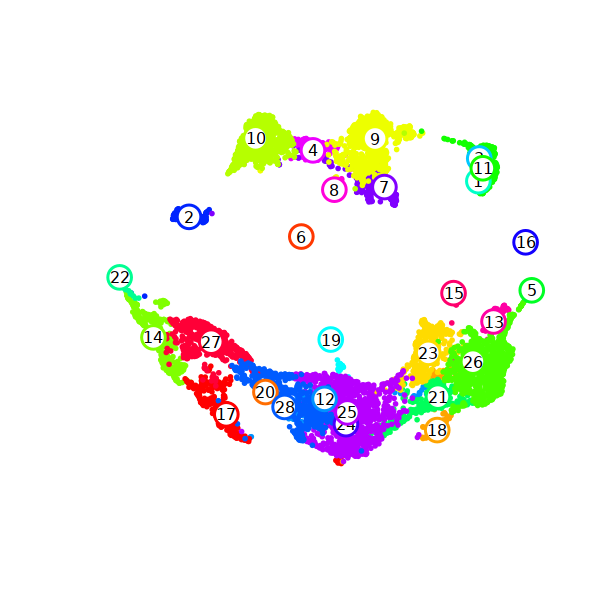

In [7]:
options(repr.plot.width = 5, repr.plot.height = 5)
umap_1 <- plotmap(sc_1, um = TRUE)
umap_2 <- plotmap(sc_2, um = TRUE)

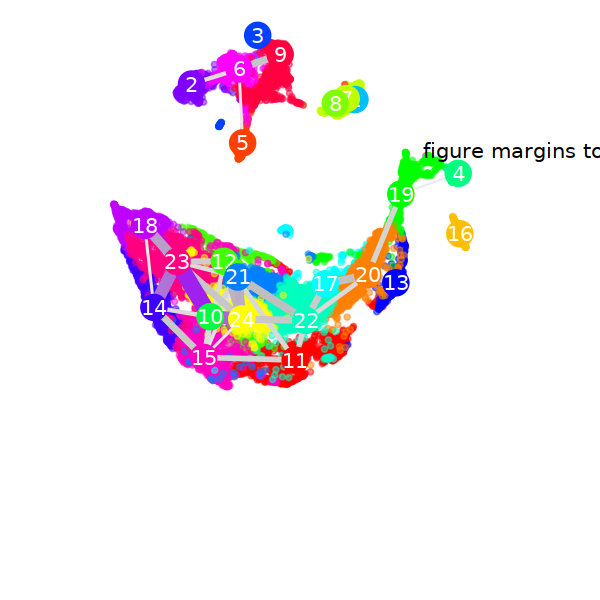

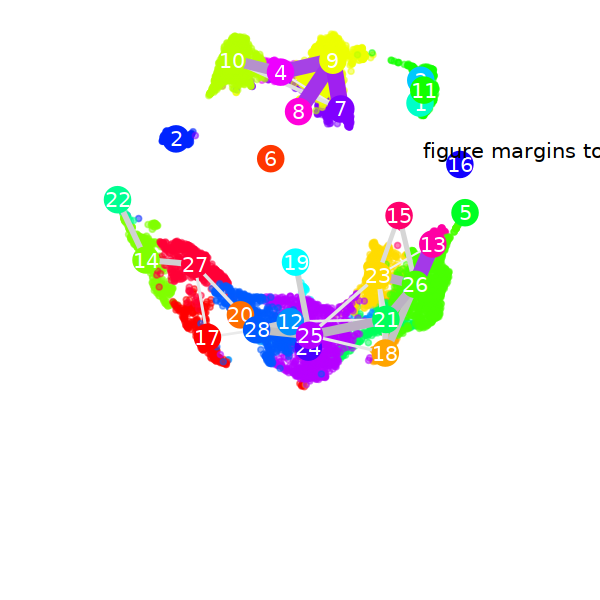

In [8]:
## map of transition probabilities
options(repr.plot.width = 5, repr.plot.height = 5)
plotTrProbs(sc_1, probs_1, tp = .5, prthr = 0.01, cthr = 0, um = TRUE)
plotTrProbs(sc_2, probs_2, tp = .5, prthr = 0.01, cthr = 0, um = TRUE)

# Combine VarID results Seurat object 

In [13]:
so_1 <- subset(so_1, cells = rownames(sc_1@umap))
so_2 <- subset(so_2, cells = rownames(sc_2@umap))

In [14]:
all(colnames(so_1) == rownames(sc_1@umap))
all(colnames(so_2) == rownames(sc_2@umap))

[1] TRUE

[1] TRUE

In [15]:
so_1$cluster <- sc_1@cluster$kpart
so_2$cluster <- sc_2@cluster$kpart

In [ ]:
so_1@reductions$varid_umap <- CreateDimReducObject(embeddings = as.matrix(sc_1@umap), assay = "RNA", key = "varid_umap")
so_2@reductions$varid_umap <- CreateDimReducObject(embeddings = as.matrix(sc_2@umap), assay = "RNA", key = "varid_umap")

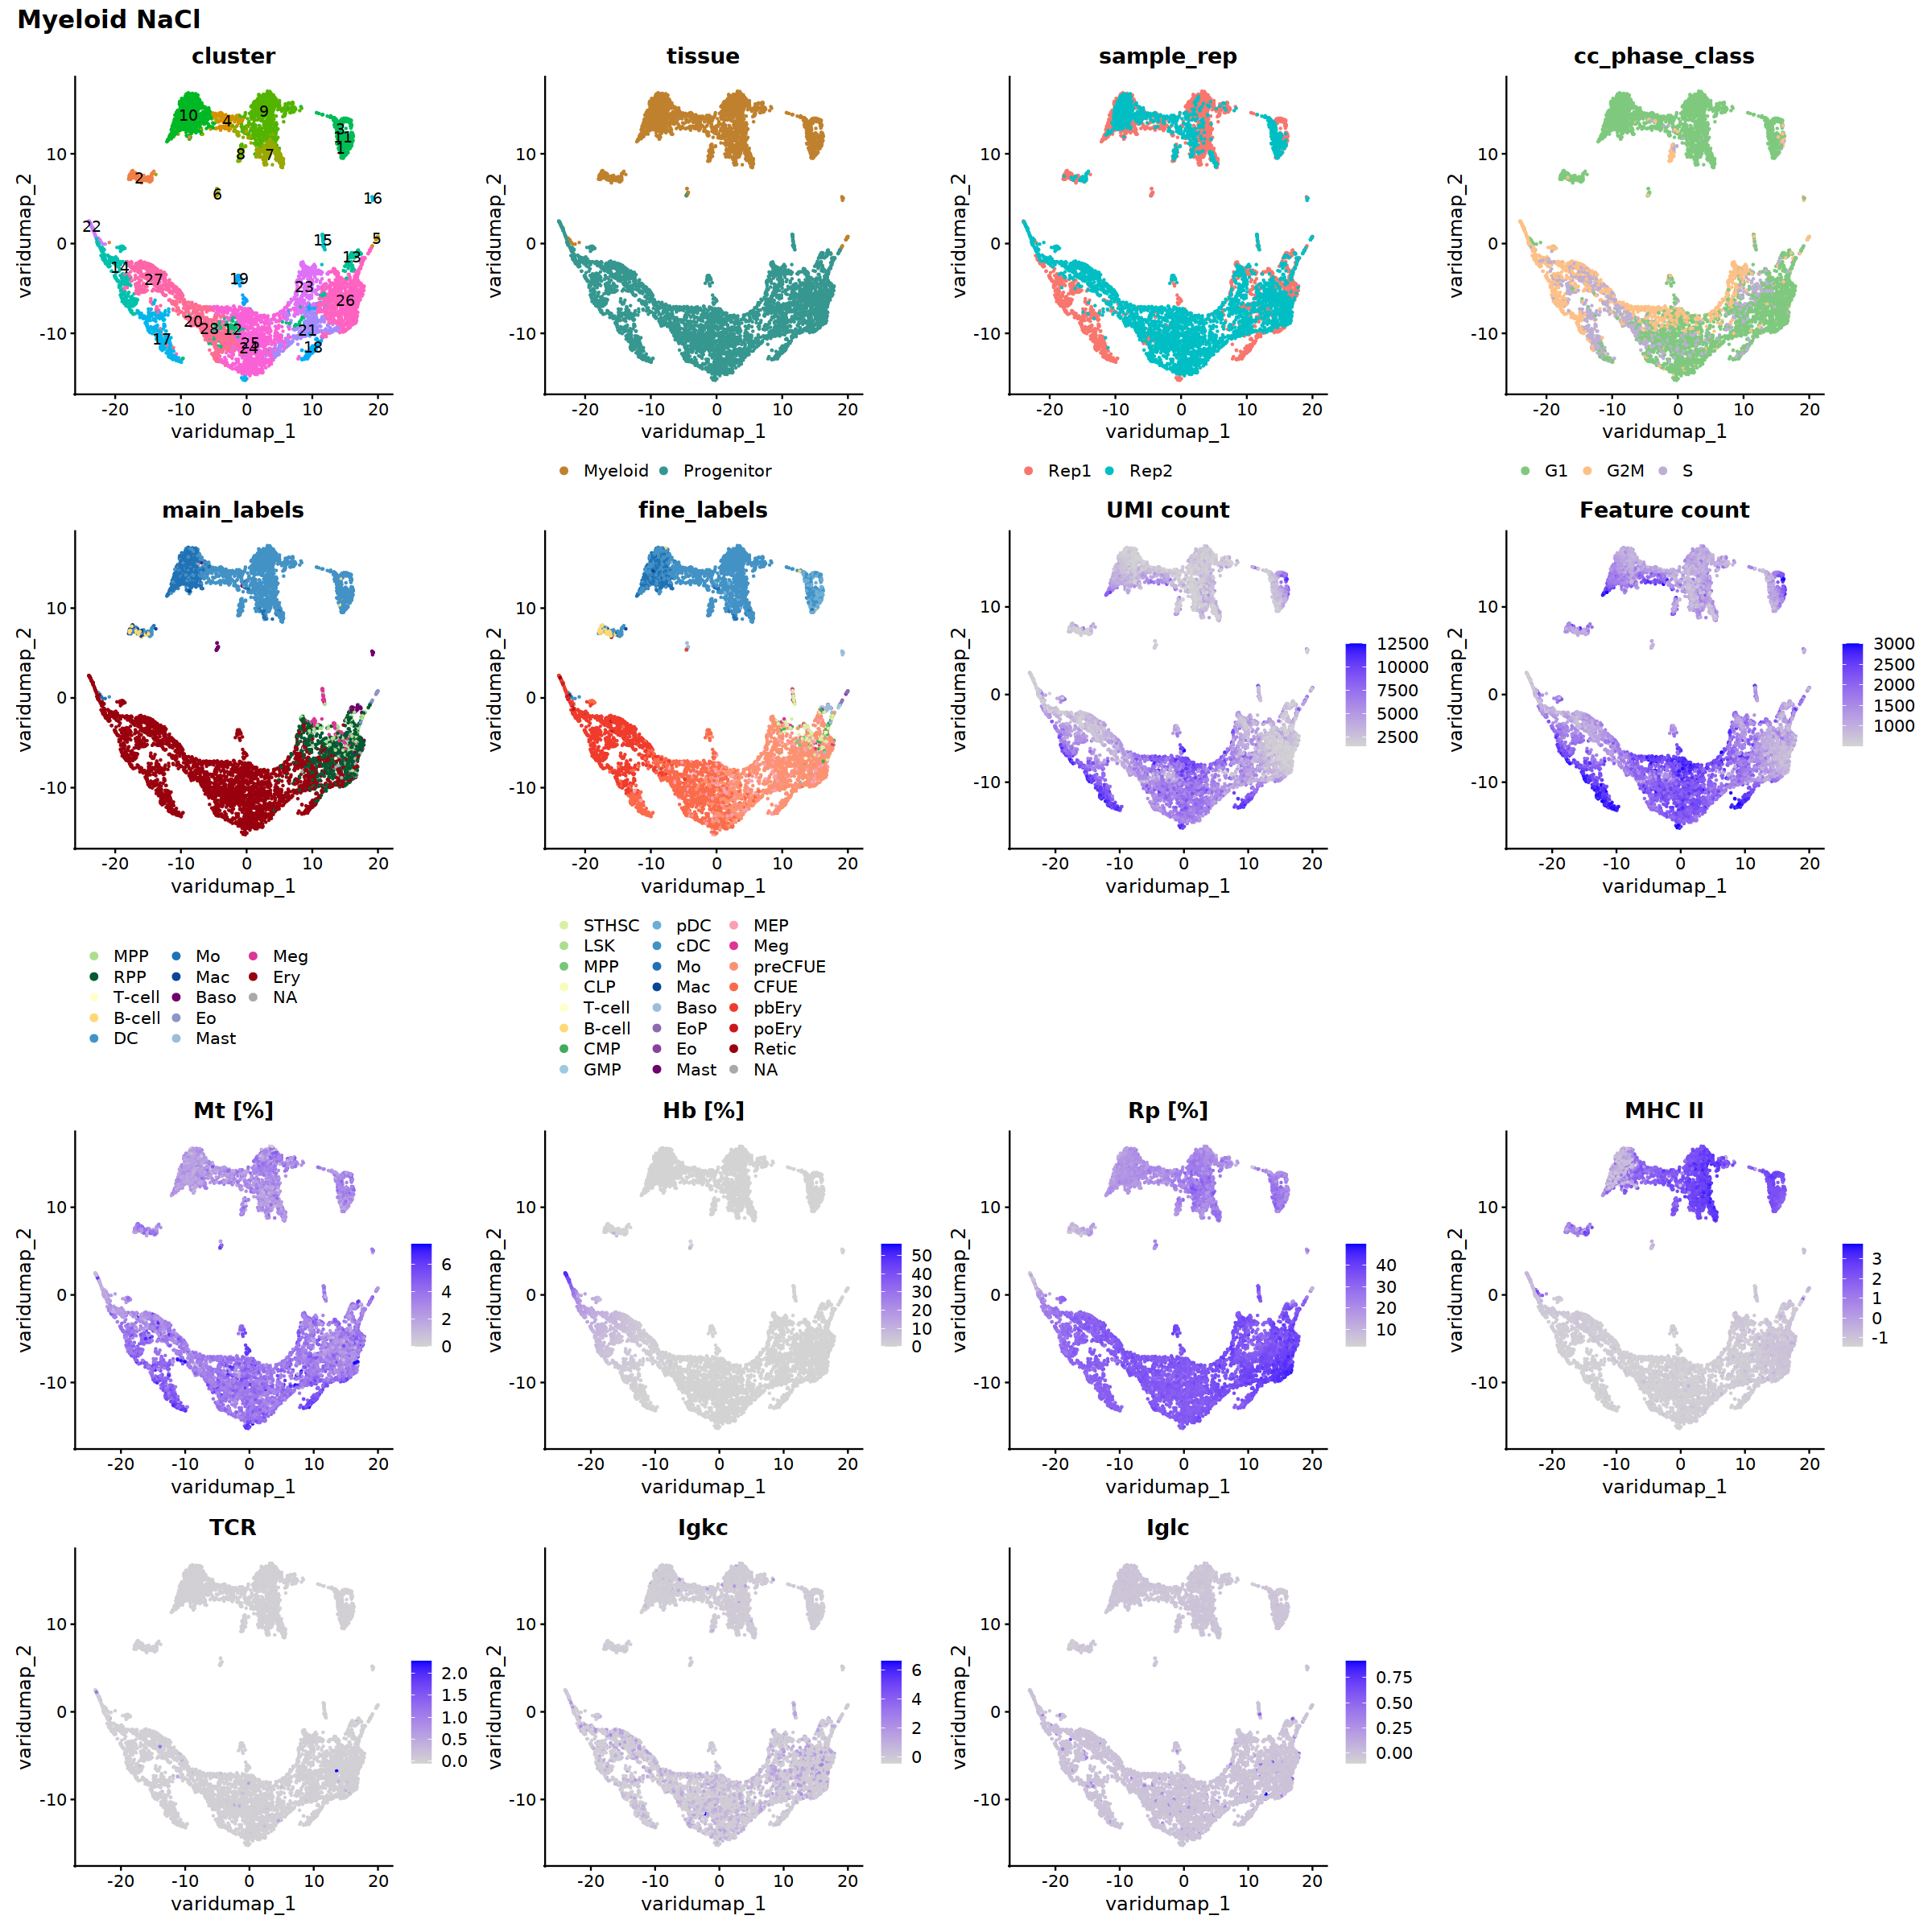

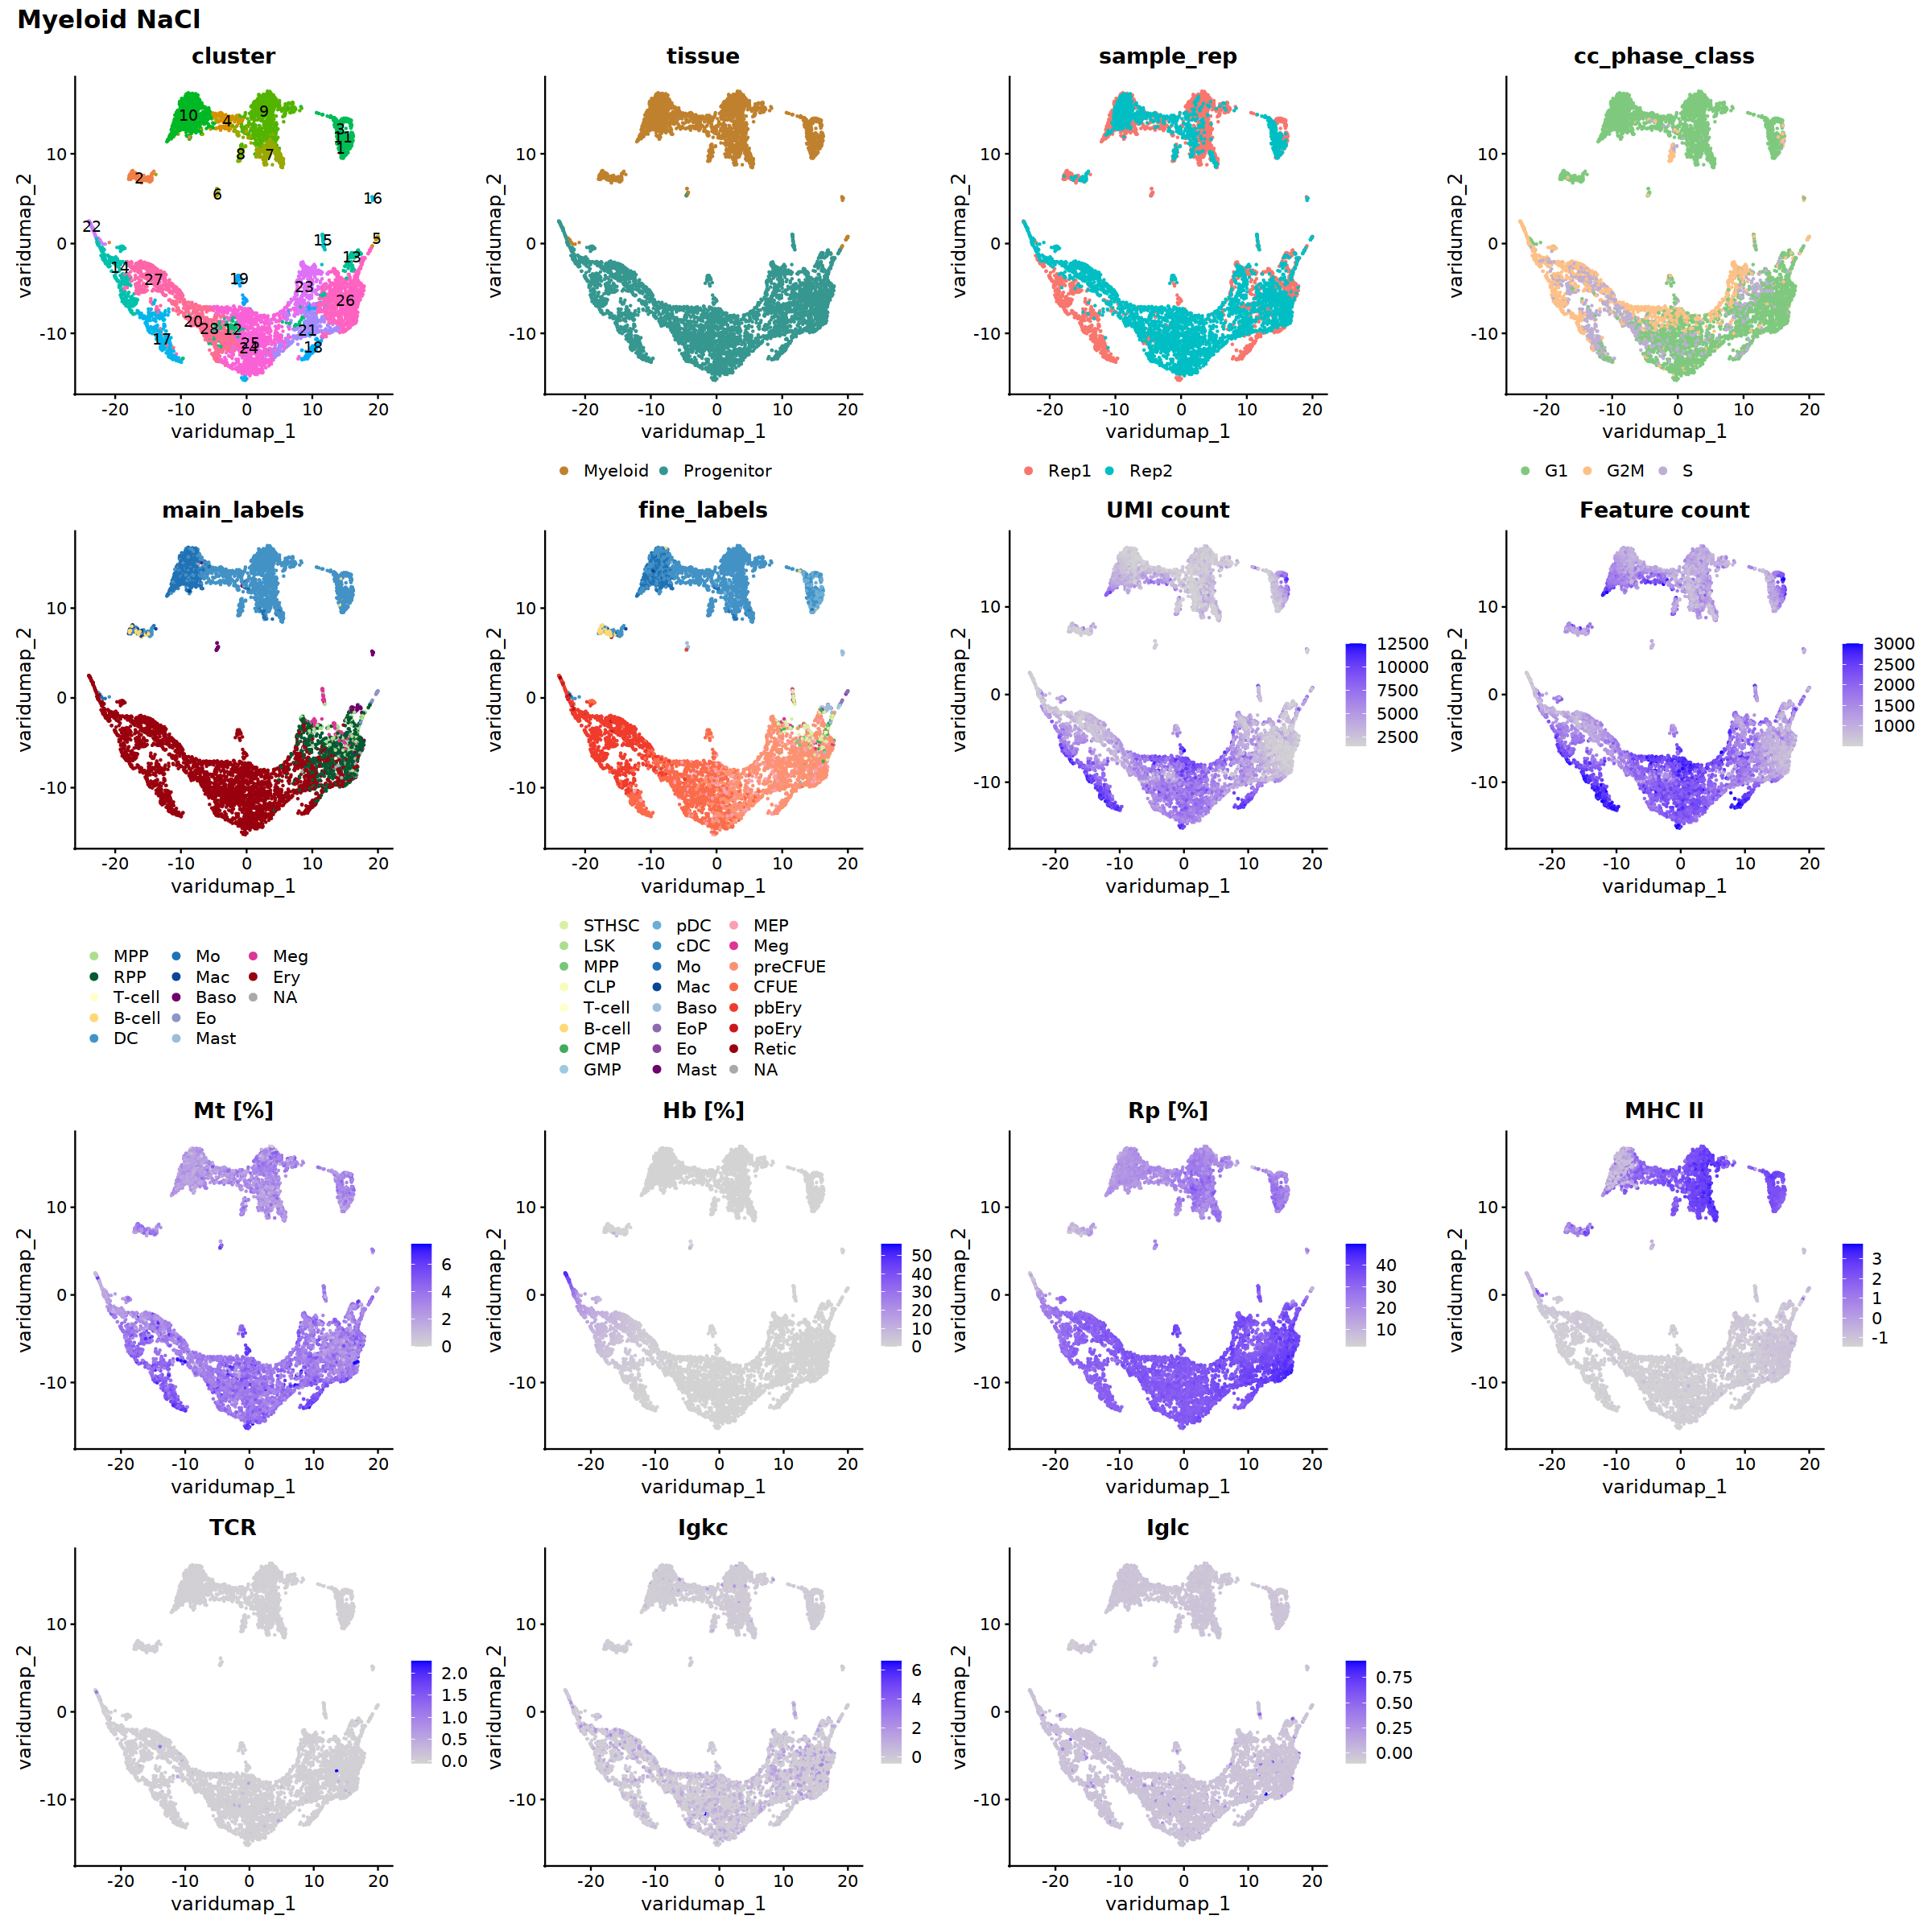

In [20]:
options(repr.plot.width = 20, repr.plot.height = 20)
dim_plot <- dim_plot(so_2, cluster = "cluster", reduction = "varid_umap")